In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 13.0.1


# Pulsed Radar

## Introduction

Pulsed radar is a type of radar system that uses short, intense pulses of radio frequency energy to detect and track objects. These pulses are transmitted by the radar antenna and then the system listens for the return echoes from objects in the radar's field of view. By measuring the time it takes for the echoes to return, the radar can determine the distance to the objects. Pulsed radar systems are commonly used in various applications such as air traffic control, weather monitoring, military surveillance, and navigation.

This illustration showcases a simple simulation of a pulsed radar using the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define Antenna patterns

In this context, we are defining the radiation patterns for both the transmitter and receiver antennas. Please note that idealized patterns are employed for this purpose, but users have the flexibility to incorporate more realistic antenna patterns into the simulation as needed.


In [3]:
antenna_gain = 20  # dBi

az_angle = np.arange(-20, 21, 1)
az_pattern = 20 * np.log10(np.cos(az_angle / 180 * np.pi) ** 500) + antenna_gain

el_angle = np.arange(-20, 21, 1)
el_pattern = 20 * np.log10((np.cos(el_angle / 180 * np.pi)) ** 400) + antenna_gain

_Plot the antenna patterns_


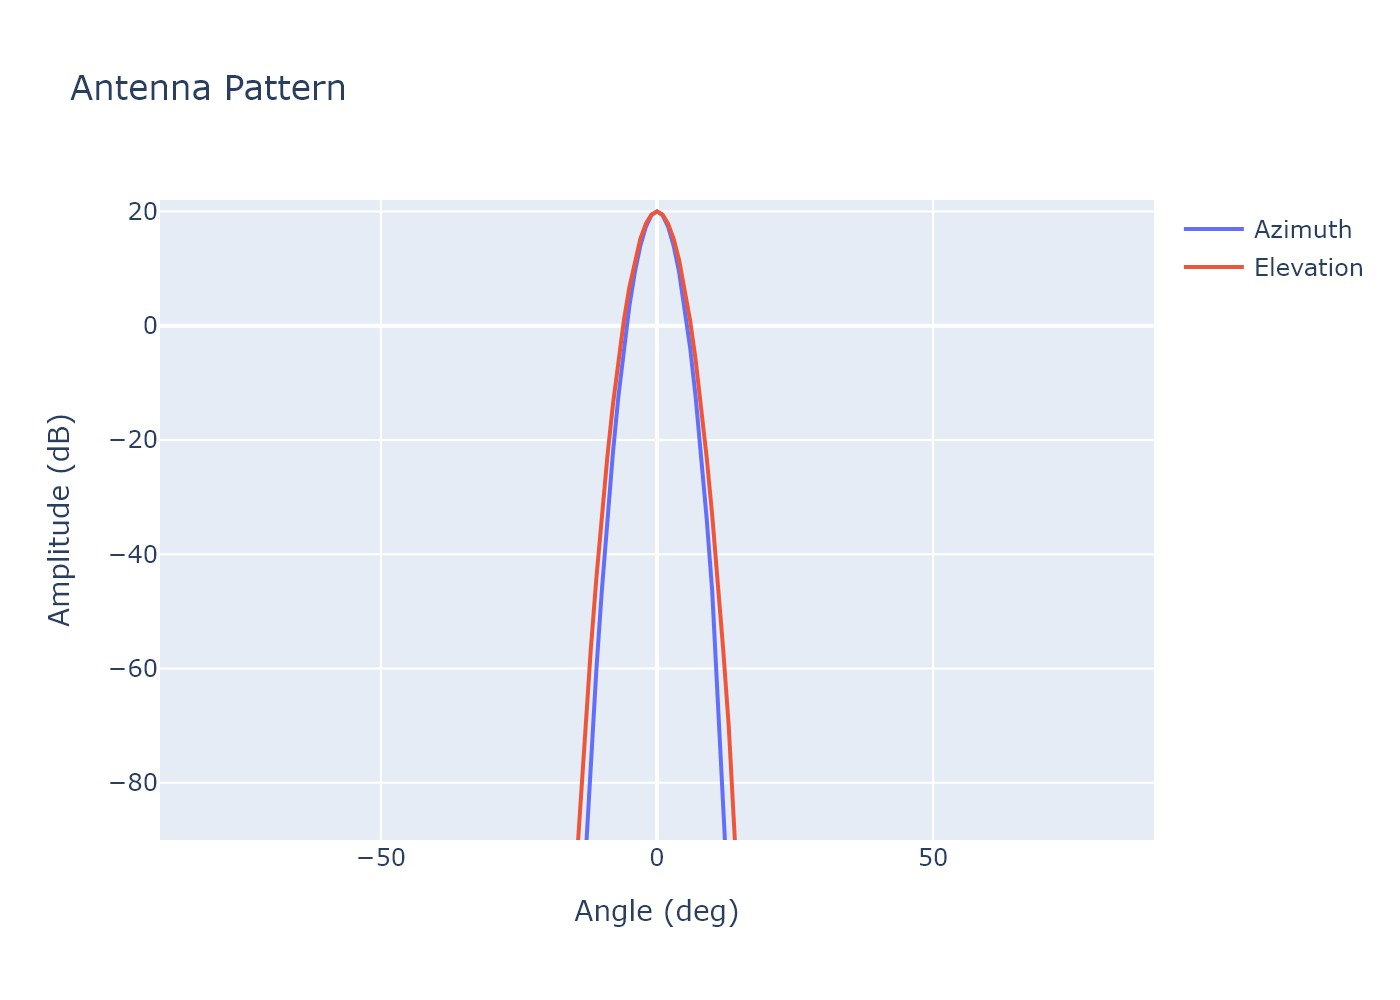

In [4]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=az_angle,
        y=az_pattern,
        name="Azimuth",
    )
)
fig.add_trace(
    go.Scatter(
        x=el_angle,
        y=el_pattern,
        name="Elevation",
    )
)

fig.update_layout(
    title="Antenna Pattern",
    yaxis=dict(title="Amplitude (dB)", range=[-90, 22]),
    xaxis=dict(title="Angle (deg)", range=[-90, 90]),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

#### Define a Transmitter

Here, the location and the radiation patterns of the transmitter channel are defined. All the other properties, such as `polarization` and `modulation`, etc, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter).

The waveform modulation properties of the transmitter channel are used to create a short rectangular pulse


In [5]:
from scipy import constants

light_speed = constants.c

max_range = 5000  # Maximum unambiguous range
range_res = 50  # Required range resolution
pulse_bw = light_speed / (2 * range_res)  # Pulse bandwidth
pulse_width = 1 / pulse_bw  # Pulse width
prf = light_speed / (2 * max_range)  # Pulse repetition frequency
prp = 1 / prf
fs = 6e6  # Sampling rate 6 msps
fc = 10e9  # Carrier frequency
num_pulse = 10

total_samples = int(prp * num_pulse * fs)
sample_per_pulse = int(total_samples / num_pulse)

mod_t = np.arange(0, total_samples) / fs  # Time series of the modulation
amp = np.zeros_like(mod_t)  # Amplitude of the modulation
amp[mod_t <= pulse_width] = 1  # Create a rectangular pulse

tx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
    amp=amp,
    mod_t=mod_t,
)

tx = Transmitter(
    f=fc,
    t=1 / prf,
    tx_power=67,  # dBm
    pulses=num_pulse,
    channels=[tx_channel],
)

_Plot the pulse_


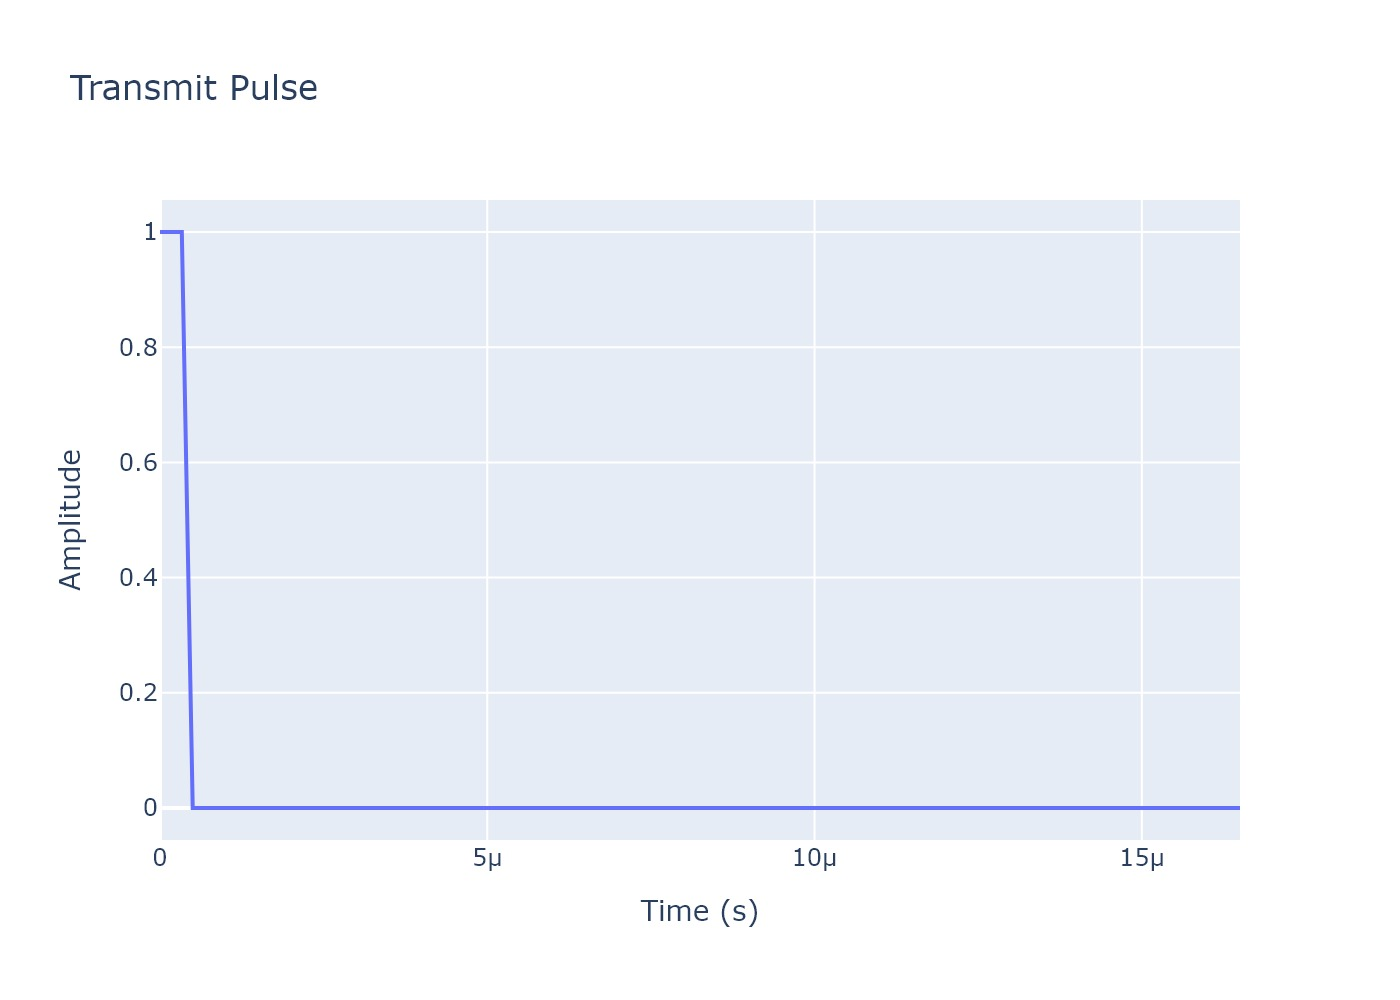

In [6]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=mod_t[0:100],
        y=amp[0:100],
        name="Transmit Pulse",
    )
)

fig.update_layout(
    title="Transmit Pulse",
    yaxis=dict(title="Amplitude"),
    xaxis=dict(title="Time (s)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Receiver Channel

Similar to the transmitter channel, the location and radiation patterns of the receiver channel are defined. All the other properties, such as `polarization`, `antenna patterns`, are using default values as listed in the [documentation](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver).


In [7]:
rx_channel = dict(
    location=(0, 0, 0),
    azimuth_angle=az_angle,
    azimuth_pattern=az_pattern,
    elevation_angle=el_angle,
    elevation_pattern=el_pattern,
)

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [8]:
rx = Receiver(
    fs=fs,
    noise_figure=12,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=[rx_channel],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [9]:
radar = Radar(transmitter=tx, receiver=rx)

### Targets

The propertities of targets are defined here. There are 3 targets in this simulation. The locations of the targets are defined through $(x, y, z)$ coordinates in meters, and the speeds of the targets are defined trough $(v_x, v_y, v_z)$ in $m/s$. The propertites of the targets also includes radar cross-section (RCS (dBsm)) and phase (degree).


In [10]:
target_1 = dict(location=(2000, 0, 0), speed=(0, 0, 0), rcs=10, phase=0)
target_2 = dict(location=(3000, 0, 0), speed=(0, 0, 0), rcs=10, phase=0)

targets = [target_1, target_2]

## Simulate Baseband Signals

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [11]:
from radarsimpy.simulator import sim_radar

data = sim_radar(radar, targets)
timestamp = data["timestamp"]
baseband = data["baseband"] + data["noise"]

_Plot the baseband samples_


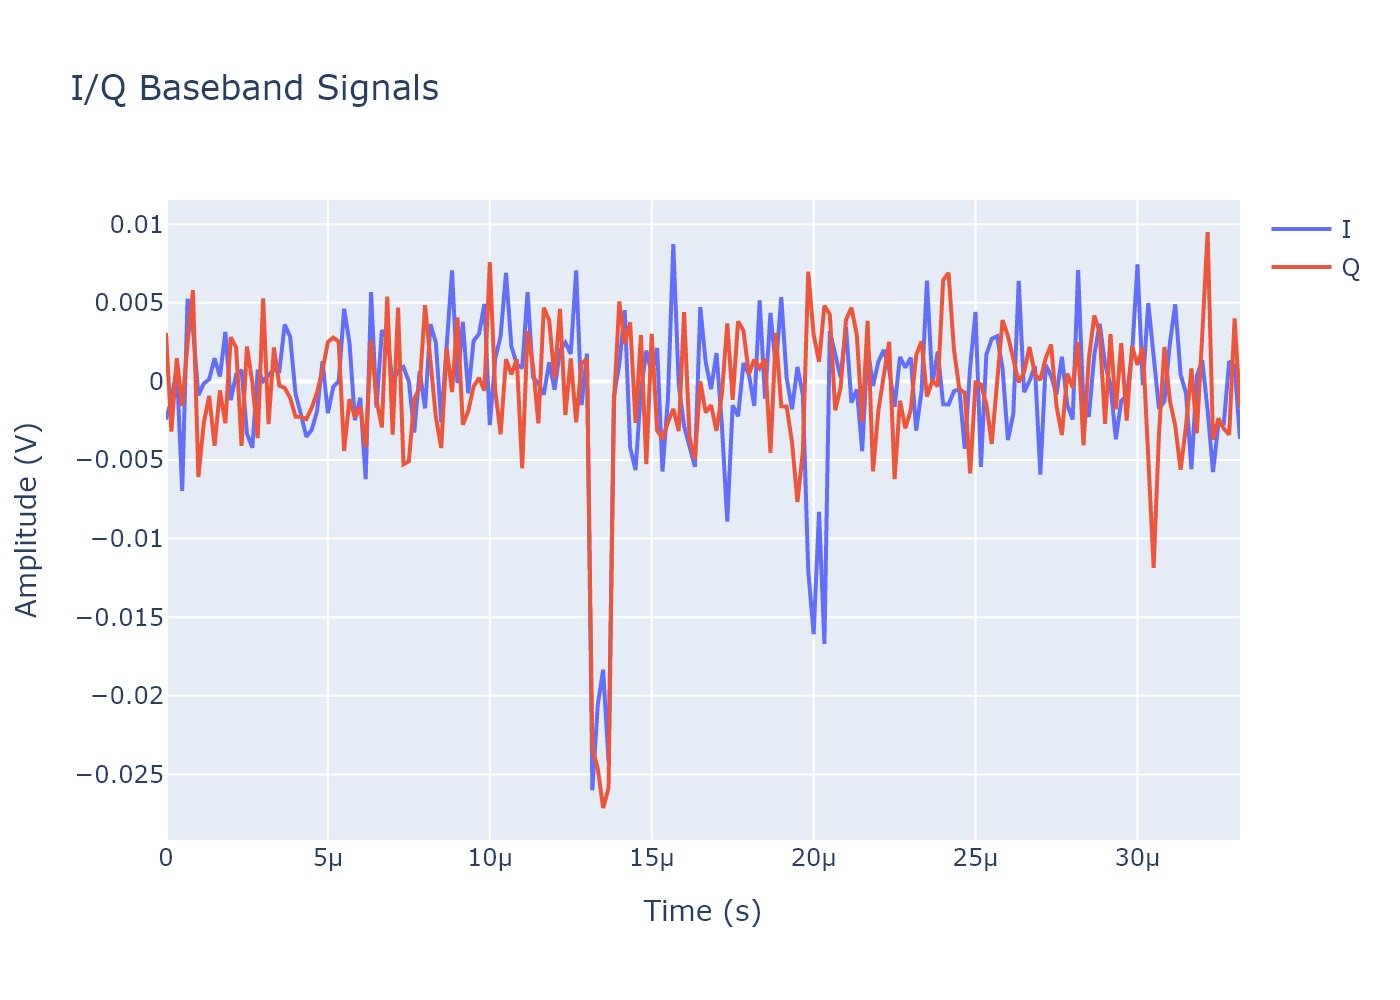

In [12]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.real(baseband[0, 0, :]),
        name="I",
    )
)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.imag(baseband[0, 0, :]),
        name="Q",
    )
)

fig.update_layout(
    title="I/Q Baseband Signals",
    yaxis=dict(title="Amplitude (V)"),
    xaxis=dict(title="Time (s)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Signal Processing


The matched filter offers a processing gain which improves the detection threshold. It convolves the received signal with a local, time-reversed, and conjugated copy of transmitted waveform. Therefore, we must specify the transmitted waveform when creating our matched filter. The received pulses are first passed through a matched filter to improve the SNR before doing pulse integration, threshold detection, etc.


In [13]:
from scipy import signal

matchingcoeff = amp[amp != 0]
range_profile = np.zeros_like(baseband, dtype=np.complex128)

for p_idx in range(0, num_pulse):
    range_profile[0, p_idx, :] = signal.convolve(
        baseband[0, p_idx, :], matchingcoeff, mode="same"
    )

With a pulsed radar, we can integrate multiple pulses to improve the SNR. Non-coherent integration is used here.


In [14]:
range_profile_integrated = np.sum(np.abs(range_profile[0, :, :]), axis=0)

_Plot the range profile_


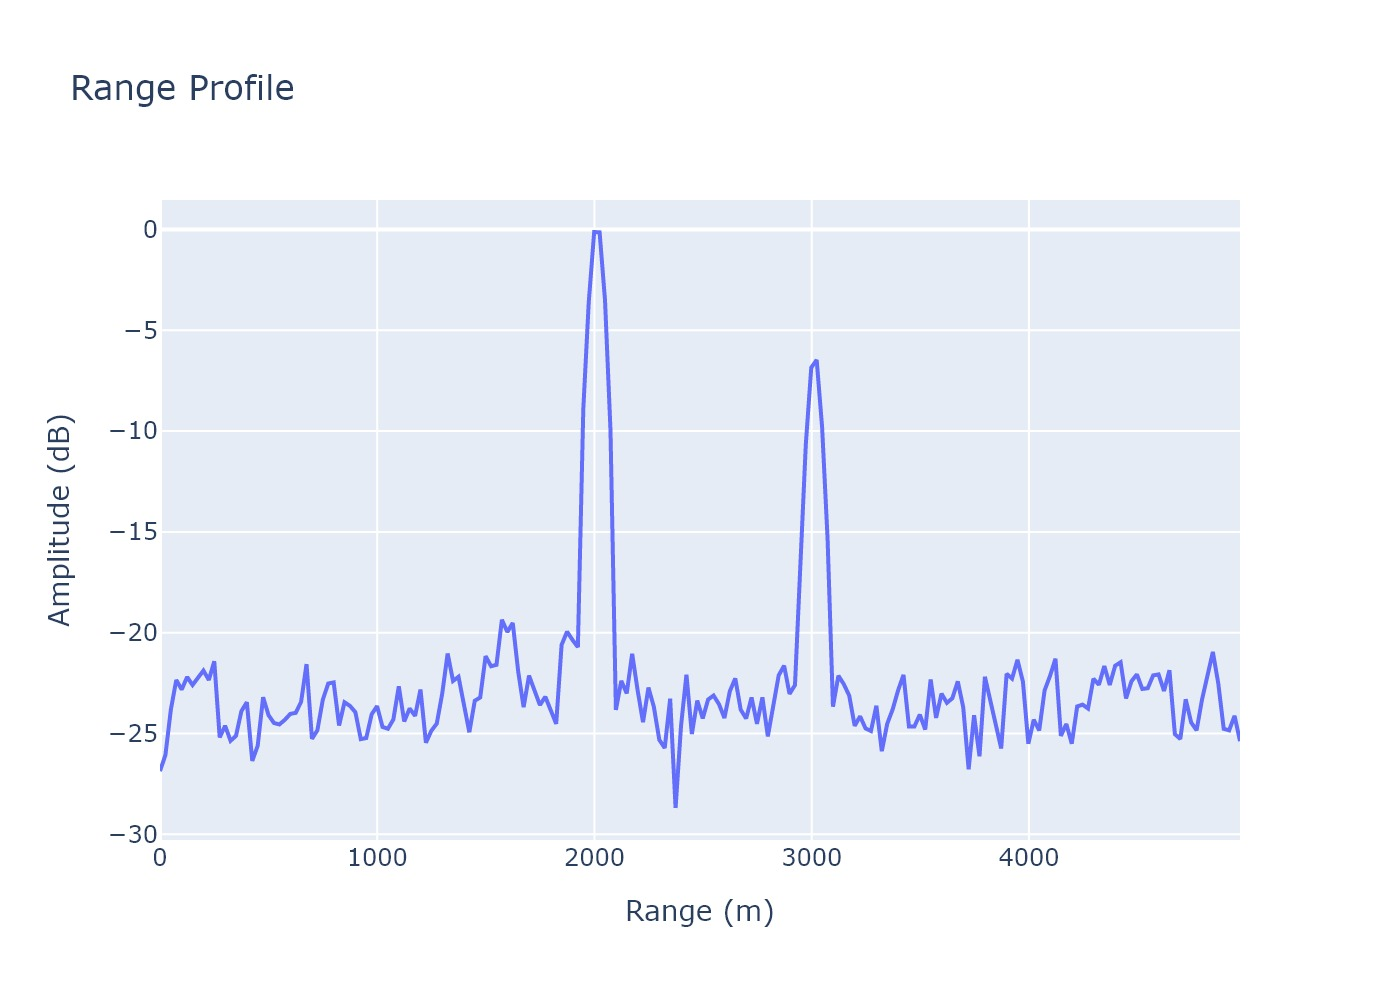

In [15]:
range_axis = mod_t * light_speed / 2

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(range_profile_integrated),
        name="I",
    )
)

fig.update_layout(
    title="Range Profile",
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))